In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import numpy as np
import torch
from geometry import *
from utils import Plot_Grid
from solver import *
from models import *
from mesh import *
from boundary import *
import matplotlib.pyplot as plt
%matplotlib inline
from models.neural_net import _init_weights

In [2]:
nx, ny = 80, 80
xi, eta = np.linspace(0,1,nx), np.linspace(0,1,ny)
# xi, eta = np.meshgrid(xi_, eta_)
# anulus = Analytical_Annulus(1., 0.6, 0.5)
# grid = TFI(xi, eta, anulus)

In [3]:
#Plot_Grid(grid.X()['x'],grid.Y()['y'],nx,ny)

In [4]:
# Code the governing Equation

# give the value of tau, n and K 
tau = 0.5
n = 0.5
K = 1.5
dpdz = 10

class Guv_Eq(PDE):
    
    def PDELoss(self, inputs, outputs):
        
        # Calculate the determinant
        #jac_det = self.jacobian_det(computation)
        
        # calculate alpha 
        #alpha = self.alpha(computation)
        
        # calculate beta
        #beta = self.beta(computation)
        
        # calculate gamma
        #gamma = self.gamma(computation)
        
        # compute the gradient of U wrt inputs 
        gradient = self.compute_grad(outputs, inputs)
        
        # seperate dudxi and dudeta
        dudxi = gradient[:,0]
        dudeta = gradient[:,1]
        
        # calculate apparent viscosity
        app_visc = self.HB_model(gradient, tau, n, K)
        
        # code part(a) of the governing equation
        left = (app_visc)*(dudxi)
        
        # code part(b) of the governing equation
        right = (app_visc)*(dudeta)
        
        # differentiate part(a) wrt xi
        d_left_dxi = self.compute_grad(left, inputs)[:,0]
        
        # differentiate part(b) wrt eta
        d_right_deta = self.compute_grad(right, inputs)[:,1]
        
        # combine the left and right with dpdz for loss function
        gov_eq = d_left_dxi + d_right_deta + dpdz
        
        return {'PDE': gov_eq}
        
    
    def shear_rate(self, gradient):
        
        # calculate the determinant
        #jac_det = self.jacobian_det(computation)
        
        # seperate the input 
        #dxdxi, dxdeta, dydxi, dydeta = self.seperate_data(computation)
        
        # seperate the gradients
        dudxi = gradient[:,0]
        dudeta = gradient[:,1]
        
        # compute the shear rate
        sr_  = (((dudxi)**2 + (dudeta)**2)**0.5)
        #print(sr_)
        
        sr = torch.where(sr_ >torch.from_numpy(np.array([1e-2])).float(),sr_ , torch.from_numpy(np.array([1e-2])).float())
        return sr
        
                         
        
    
    def Modified_HB(self, inputs, outputs):
        pass
    
    def HB_model(self, gradients,tau, n, K):
        
        # determine the shear rate
        shear_rate = self.shear_rate(gradients)
        
        # calculate the apparent viscosity
        
        app_vis_ = torch.abs_((tau/shear_rate) + ((shear_rate)**(n-1))*K)
        
        #app_vis = torch.where(app_vis_>torch.from_numpy(np.array([1e-2])).float(),app_vis_,torch.from_numpy(np.array([1e-2])).float())
        
        return app_vis_
    

# initiate the PDE equation
pde = Guv_Eq(inputs=('xi', 'eta'), outputs='u')


pass


In [5]:
# define the meshing data
mesh = Mesh({'xi':xi, 'eta':eta})

In [6]:
pde.set_mesh(mesh)

In [7]:
# when u = 0 @ eta = 0,1
eta_ = np.array([0,1])
u_ = np.full(2*len(xi), 0)
pipe = Dirichlet({'xi':xi, 'eta':eta_}, {'u':u_}, name='Pipe')
pde.add_boundary(pipe)

In [8]:
# when dudxi = 0 @ xi = 0,1
xi_ = np.array([0,1])
class Neumann(Neumann):
    def neumann_loss(self, inputs, outputs):
        dudxi = self.compute_grad(outputs, inputs)[:,0]
        return {'gradXi': dudxi}
outer = Neumann({'xi':xi_, 'eta':eta}, name='left_flank')
pde.add_boundary(outer)

In [9]:
btach_size = 1024
lr = 0.0001
epochs = 1000
hid_dim = 256
layers = 21
in_dim = len(pde.input)
out_dim = len(pde.output)
#activation = Sine()
activation = torch.nn.Tanh()

net = MLP(in_dim, out_dim, layers, hid_dim, act=activation)
#net.apply(_init_weights)

optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,cycle_momentum=True)

pde.compile(net,optimizer, scheduler)

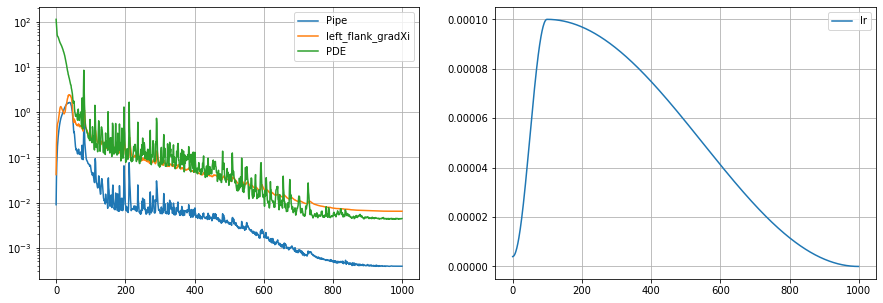

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


Wall time: 1h 34min 21s


In [10]:
%time hist = pde.solve(epochs, btach_size)

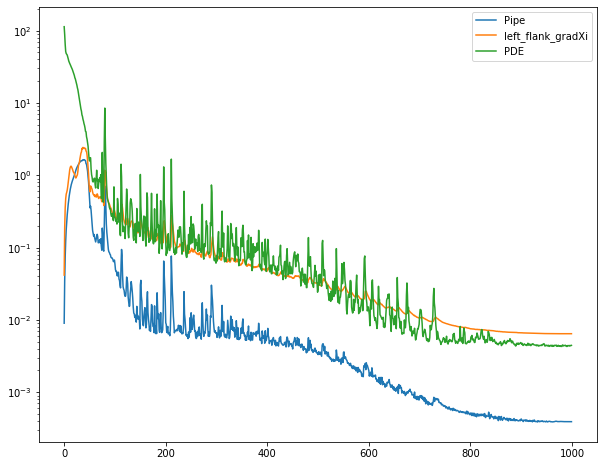

In [11]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

In [12]:
x = np.linspace(0,1,60)
y = np.linspace(0,1,60)

eval_mesh = Mesh({'x':x, 'y':y})
pred = pde.eval(eval_mesh).view(len(y),len(x)).numpy()

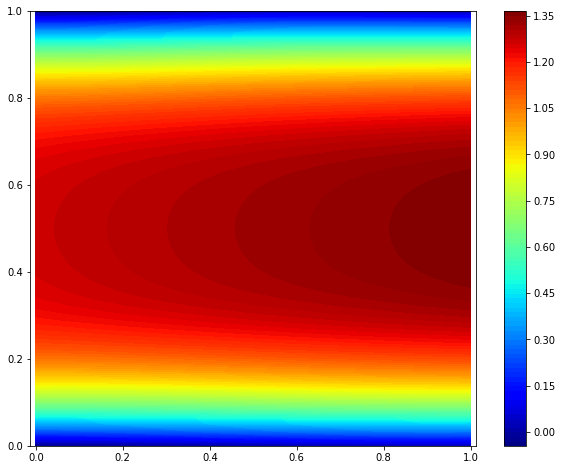

In [13]:
xi, eta = np.meshgrid(x,y)
plt.figure(figsize=(10,8))
plt.contourf(xi, eta, pred, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

In [14]:
pred

array([[-0.03200546, -0.03117231, -0.03018088, ...,  0.0253686 ,
         0.02485297,  0.02420228],
       [ 0.11533922,  0.11577749,  0.11639914, ...,  0.16912666,
         0.16870156,  0.16815466],
       [ 0.2513299 ,  0.25139096,  0.25166795, ...,  0.3021569 ,
         0.30183786,  0.30141246],
       ...,
       [ 0.24184173,  0.24169007,  0.24190718, ...,  0.29005864,
         0.28979835,  0.28956679],
       [ 0.10477184,  0.10487936,  0.10537991, ...,  0.1540585 ,
         0.1535939 ,  0.15316871],
       [-0.04438289, -0.04392169, -0.04304535, ...,  0.00690299,
         0.00621663,  0.00557614]], dtype=float32)